In [16]:
import asyncio
import logging
import os
from typing import Annotated, Literal, TypedDict

import streamlit as st
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_cohere import CohereEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, BaseMessage, convert_to_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_pinecone import PineconeVectorStore
from langgraph.graph import END, StateGraph, add_messages
from typing_extensions import TypedDict

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
logger.setLevel(logging.INFO)

os.environ["TAVILY_API_KEY"] = st.secrets["TAVILY_API_KEY"]
os.environ["COHERE_API_KEY"] = st.secrets["COHERE_API_KEY"]
os.environ["PINECONE_API_KEY"] = st.secrets["PINECONE_API_KEY"]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = st.secrets["LANGCHAIN_API_KEY"]
PINECONE_INDEX = st.secrets["PINECONE_INDEX"]

MAX_RETRIES = 3
VERBOSE = False

tavily_search_tool = TavilySearchResults(max_results=3)
embeddings = CohereEmbeddings(cohere_api_key=st.secrets["COHERE_API_KEY"])
vectorstore = PineconeVectorStore(index_name=PINECONE_INDEX, embedding=embeddings)
retriever = vectorstore.as_retriever()
llm = ChatGroq(model="llama3-8b-8192")


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        ask_question: whether to ask questions
        documents: list of documents
    """

    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool


class GraphConfig(TypedDict):
    max_retries: int


def document_search(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if VERBOSE:
        logger.info("---RETRIEVE---")

    question = convert_to_messages(state["messages"])[-1].content

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "web_fallback": True}


RAG_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise 
<|eot_id|><|start_header_id|>user<|end_header_id|>
Question: {question}
Context: {context}
Answer: 
<|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["context", "question"],
)


def generate(state: GraphState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if VERBOSE:
        logger.info("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1

    rag_chain = RAG_PROMPT | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"retries": retries + 1, "candidate_answer": generation}


QUERY_REWRITER_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
Look at the input and try to reason about the underlying semantic intent / meaning. 
<|eot_id|><|start_header_id|>user<|end_header_id|>
Here is the initial question: \n\n {question} \n Formulate an improved question. 
<|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)


def transform_query(state: GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    if VERBOSE:
        logger.info("---TRANSFORM QUERY---")

    question = state["question"]

    # Re-write question
    query_rewriter = QUERY_REWRITER_PROMPT | llm | StrOutputParser()
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}


def web_search(state: GraphState):
    if VERBOSE:
        logger.info("---RUNNING WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]
    search_results = tavily_search_tool.invoke(question)
    search_content = "\n".join([d["content"] for d in search_results])
    documents.append(
        Document(page_content=search_content, metadata={"source": "websearch"})
    )
    return {"documents": documents, "web_fallback": False}


def finalize_response(state: GraphState):
    if VERBOSE:
        logger.info("---FINALIZING THE RESPONSE---")

    return {"messages": [AIMessage(content=state["candidate_answer"])]}


class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


HALLUCINATION_GRADER_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no', where 'yes' means that the answer is grounded in / supported by the set of facts.

IF the generation includes code examples, make sure those examples are FULLY present in the set of facts, otherwise always return score 'no'. 
<|eot_id|><|start_header_id|>user<|end_header_id|>
Set of facts: \n\n {documents} \n\n LLM generation: {generation}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["documents", "generation"],
)


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


ANSWER_GRADER_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no', where 'yes' means that the answer resolves the question. 
<|eot_id|><|start_header_id|>user<|end_header_id|>
User question: \n\n {question} \n\n LLM generation: {generation}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "generation"],
)


def grade_generation_v_documents_and_question(
    state: GraphState, config
) -> Literal["generate", "transform_query", "web_search", "finalize_response"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    # this means we've already gone through web fallback and can return to the user
    if not web_fallback:
        return "finalize_response"

    if VERBOSE:
        logger.info("---CHECK HALLUCINATIONS---")

    hallucination_grader = HALLUCINATION_GRADER_PROMPT | llm.with_structured_output(
        GradeHallucinations
    )
    hallucination_grade: GradeHallucinations = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination
    if hallucination_grade.binary_score == "no":
        if VERBOSE:
            logger.info(
                "---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---"
            )
        return "generate" if retries < max_retries else "web_search"

    if VERBOSE:
        logger.info("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        logger.info("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grader = ANSWER_GRADER_PROMPT | llm.with_structured_output(GradeAnswer)
    answer_grade: GradeAnswer = answer_grader.invoke(
        {"question": question, "generation": generation}
    )
    if answer_grade.binary_score == "yes":
        if VERBOSE:
            logger.info("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        if VERBOSE:
            logger.info("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "transform_query" if retries < max_retries else "web_search"


workflow = StateGraph(GraphState, config_schema=GraphConfig)

# Define the nodes
workflow.add_node("document_search", document_search)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("document_search")
workflow.add_edge("document_search", "generate")
workflow.add_edge("transform_query", "document_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges("generate", grade_generation_v_documents_and_question)

# Compile
graph = workflow.compile()

In [18]:
for output in graph.stream({"messages": [("human", 'hello')]}):
    for key, value in output.items():
        
        print(key, value)

document_search {'question': 'hello', 'documents': [], 'web_fallback': True}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


generate {'candidate_answer': "I don't know.", 'retries': 0}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


generate {'candidate_answer': "I don't have any context to work with, so I don't have an answer for you.", 'retries': 1}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


generate {'candidate_answer': "I don't know.", 'retries': 2}


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


generate {'candidate_answer': "I don't know.", 'retries': 3}
web_search {'documents': [Document(metadata={'source': 'websearch'}, page_content='Listen to "Easy On Me" here: http://Adele.lnk.to/EOMPre-order Adele\'s new album "30" before its release on November 19: https://www.adele.comShop the "Adele...\nP.S. first cost of sender & receiver to manufacture is only $7.00.[12]\nBy 1889, central telephone exchange operators were known as \'hello-girls\' because of the association between the greeting and the telephone.[14][15]\nA 1918 fiction novel uses the spelling "Halloa" in the context of telephone conversations.[16]\nHullo, hallo, and other spellings\nHello might be derived from an older spelling variant, hullo, which the American Merriam-Webster dictionary describes as a "chiefly British variant of hello",[17] and which was originally used as an exclamation to call attention, an expression of surprise, or a greeting. It also connects the development of hello to the influence of an ea

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


generate {'candidate_answer': 'I don\'t know. The context doesn\'t seem to be related to the greeting "hello".', 'retries': 4}
finalize_response {'messages': [AIMessage(content='I don\'t know. The context doesn\'t seem to be related to the greeting "hello".')]}


In [15]:

inputs = {"messages": [("human", 'hello')]}
async for event in graph.astream_events(inputs, version="v2"):
    if (
        event["event"] == "on_chat_model_stream"
        and event['metadata']['langgraph_step'] == 7
    ):
        print(event["data"]["chunk"].content, end="", flush=True)


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I don't know.

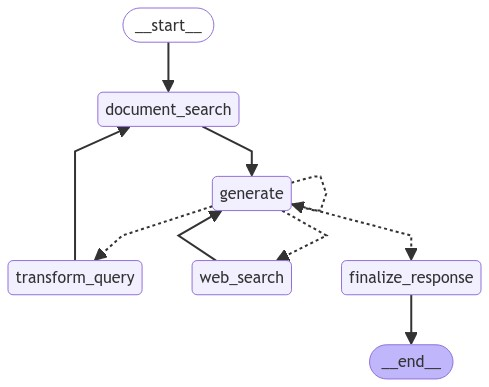

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))